# Sammensetning av alt

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from LSTM import long_short_term_memory as LSTM
from rf import rf

#### Colors

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaign=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']
    
    df, mode = df[features], df['Mode']
    return df, mode


'''
    Returns a sequence indicating if a handover has happened when predicting 1 timestep ahead
'''
def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def check_handover_array(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y[i] == y[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y[i] == 0 and y[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y[i] == 1 and y[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

## LSTM-prediction of signal strength indicators

In [4]:
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'

df, mode = read_dataset('datasets/Op1_merged.csv', campaign=campaign)
test_idx = 3 * df.shape[0] // 4

train, mode_train, test, mode_test = df[0 : test_idx], mode[0 : test_idx], df[test_idx ::], mode[test_idx ::]

results = {}
target_features = ['RSRP', 'SINR', 'RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [6]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            results[used_features] = LSTM(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=5, n_steps_out=1)

RSRP -> RSRP
RSRP, SINR -> RSRP
RSRP, RSRQ -> RSRP
RSRP, SINR, RSRQ -> RSRP
RSRP, SSS_RSRP -> RSRP
RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ -> RSRP
SINR -> SINR
RSRP, SINR -> SINR
SINR, RSRQ -> SINR
RSRP, SINR, RSRQ -> SINR
SINR, SSS_SINR -> SINR
RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ -> SINR
RSRQ -> RSRQ
RSRP, RSRQ -> RSRQ
SINR, RSRQ -> RSRQ
RSRP, SINR, RSRQ -> RSRQ
RSRQ, SSS_RSRQ -> RSRQ
RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ -> RSRQ


In [7]:
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'loss', 'val_loss'], axis=1)
df_results

,Combination,loss_final,val_loss_final,mad,mad?
0,RSRP -> RSRP,0.00091,0.00122,5.5,1.95
1,"RSRP, SINR -> RSRP",0.00089,0.00119,6.0,1.44
2,"RSRP, RSRQ -> RSRP",0.00090,0.00076,6.1,1.06
3,"RSRP, SINR, RSRQ -> RSRP",0.00089,0.00116,5.9,1.43
4,"RSRP, SSS_RSRP -> RSRP",0.00092,0.00101,6.0,1.38
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00098,0.00101,6.1,1.34
6,SINR -> SINR,0.00089,0.00192,5.1,0.42
7,"RSRP, SINR -> SINR",0.00086,0.00202,5.3,0.58
8,"SINR, RSRQ -> SINR",0.00089,0.00194,5.1,0.44
9,"RSRP, SINR, RSRQ -> SINR",0.00090,0.00243,5.6,1.22


## Classification of mode using Random Forest

In [8]:
X, mode = read_dataset('datasets/Op1_merged.csv', campaign=campaign, features=['RSRP', 'RSRQ'])
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], ['SINR', 'RSRQ'], ['SINR', 'RSRP'], ['RSRP', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ']]

rf_results = {}

print(np.sum(mode_test))
print(np.sum(mode_train))

for features in feature_selection:
    used_features = ', '.join(features)
    feats = features.copy()
    rf_results[used_features] = rf(X_train=train[features], X_test=test[features], mode_train=mode_train, mode_test=mode_test)

rf_results_df = pd.DataFrame.from_dict(rf_results, orient='index')
rf_results_df.reset_index(inplace=True)
rf_results_df.rename(columns={'index': 'Combination'}, inplace=True)
rf_results_df = rf_results_df.drop(['y_true', 'y_pred', 'model'], axis=1)
rf_results_df

24
1821


,Combination,Accuracy,Precision,Recall
0,RSRP,0.824349,0.044521,0.541667
1,SINR,0.636584,0.000000,0.000000
2,RSRQ,0.703210,0.000000,0.000000
3,"SINR, RSRQ",0.655966,0.000000,0.000000
4,"SINR, RSRP",0.575409,0.000000,0.000000
5,"RSRP, RSRQ",0.787402,0.000000,0.000000
6,"RSRP, SINR, RSRQ",0.683828,0.000000,0.000000


## Plots

In [9]:
hos_5g = check_handover(mode_test, '5g')
hos_4g = check_handover(mode_test, '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

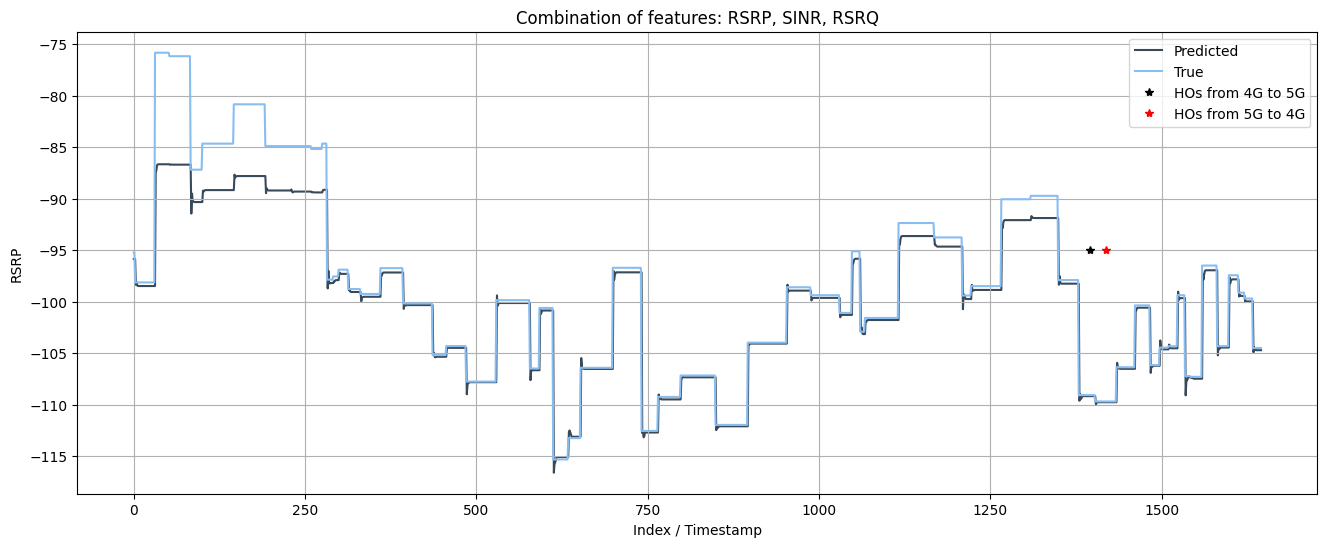

In [10]:
selected_rsrp_comb = 'RSRP, SINR, RSRQ -> RSRP'
rsrp_comb = results[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred']
rsrp_true = rsrp_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=1)
plt.plot(rsrp_true, label='True', color=rsrp_colors[2], zorder=2)
plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
plt.title(f'Combination of features: RSRP, SINR, RSRQ')
plt.legend()
plt.show()

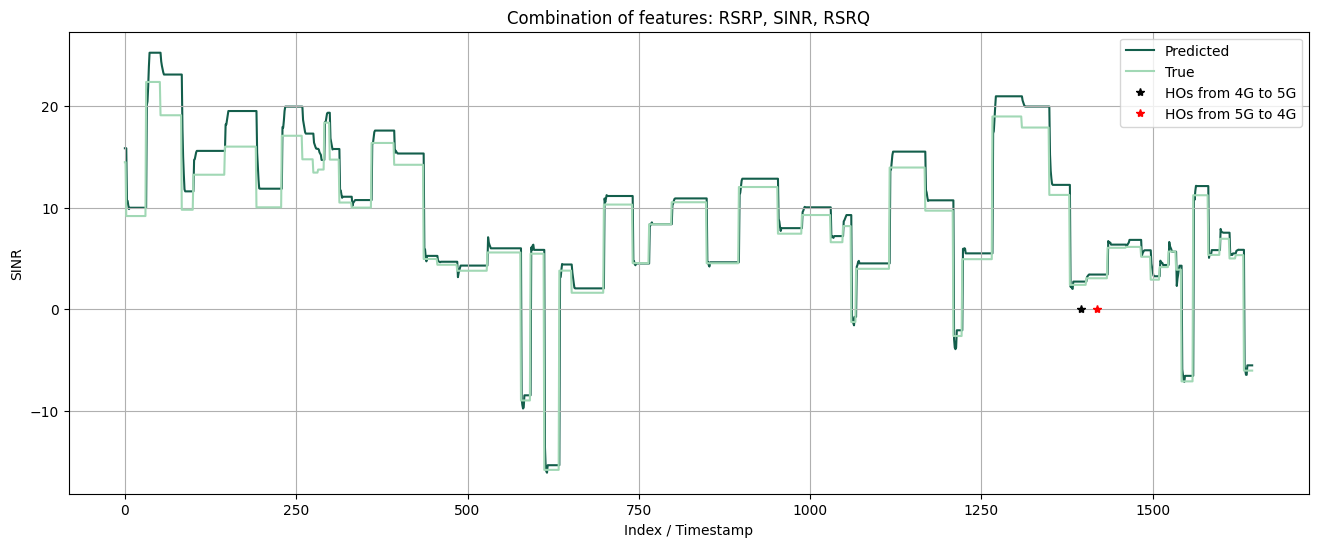

In [11]:
selected_sinr_comb = 'RSRP, SINR, RSRQ -> SINR'
sinr_comb = results[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred']
sinr_true = sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(sinr_pred, label='Predicted', color=sinr_colors[0], zorder=1)
plt.plot(sinr_true, label='True', color=sinr_colors[2], zorder=2)
plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Combination of features: RSRP, SINR, RSRQ')
plt.legend()
plt.show()

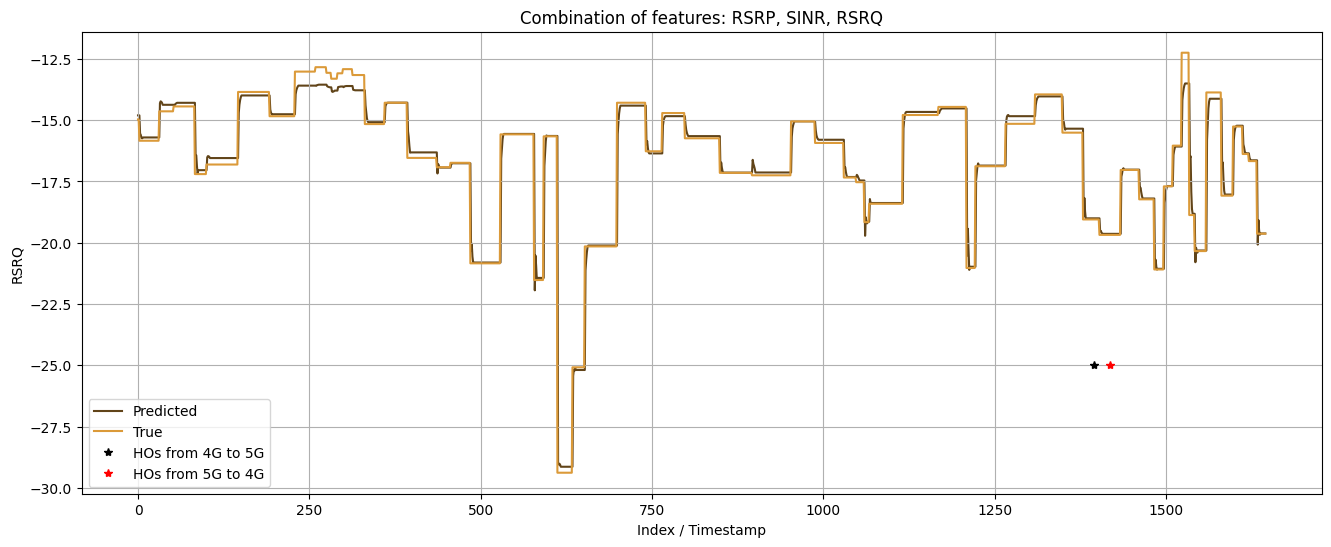

In [12]:
selected_rsrq_comb = 'RSRP, SINR, RSRQ -> RSRQ'
rsrq_comb = results[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred']
rsrq_true = rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=1)
plt.plot(rsrq_true, label='True', color=rsrq_colors[2], zorder=2)
plt.plot(when_5g_ho, [-25 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [-25 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRQ')
plt.title(f'Combination of features: RSRP, SINR, RSRQ')
plt.legend()
plt.show()

In [13]:
preds = pd.DataFrame({'RSRP' : [x[0] for x in rsrp_pred],
                      'SINR' : [x[0] for x in sinr_pred],
                      'RSRQ' : [x[0] for x in rsrq_pred]},
                      columns=['RSRP', 'SINR', 'RSRQ'])

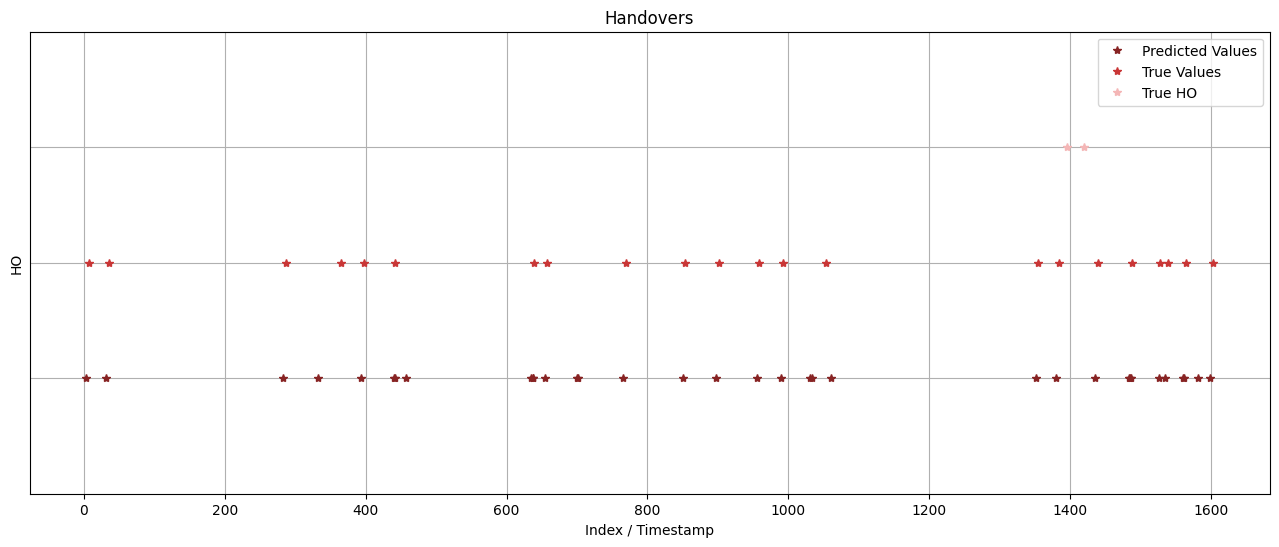

In [14]:
selected_rf_comb = 'RSRP, SINR, RSRQ'
rf_comb = rf_results[selected_rf_comb]
rf_model = rf_comb['model']
rf_pred_true = rf_comb['y_pred']

rf_pred = rf_model.predict(preds)

ho_pred_true = check_handover_array(rf_pred_true, 'both')
ho_pred = check_handover_array(rf_pred, 'both')
ho_true = check_handover(mode_test, 'both')

when_pred_true_ho = []
when_pred_ho = []
when_true_ho = []

for i in range(len(ho_pred)):
    if ho_pred_true[i] == 1:
        when_pred_true_ho.append(i)
    if ho_pred[i] == 1:
        when_pred_ho.append(i)
    if ho_true[i] == 1:
        when_true_ho.append(i)

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(when_pred_ho, [1 for _ in range(len(when_pred_ho))], '*', color=mode_colors[0], label='Predicted Values', zorder=4)
plt.plot(when_pred_true_ho, [1.5 for _ in range(len(when_pred_true_ho))], '*', color=mode_colors[1], label='True Values', zorder=2)
plt.plot(when_true_ho, [2 for _ in range(len(when_true_ho))], '*', color=mode_colors[3], label='True HO', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((0.5, 2.5))
plt.yticks([1, 1.5, 2])
plt.tick_params(left = False, labelleft = False)
plt.title(f'Handovers')
plt.legend()
plt.show()